In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# data preparation

## loading in

In [4]:
%%cmd
curl -o input.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

#can also use os.system("curl ###") as an alternative

Microsoft Windows [Version 10.0.22621.3155]
(c) Microsoft Corporation. All rights reserved.

(base) c:\Users\bruno\OneDrive\Documents\Code\python\deep_learning\Karpathy\chatgpt_>curl -o input.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  39968      0  0:00:27  0:00:27 --:--:-- 43651



(base) c:\Users\bruno\OneDrive\Documents\Code\python\deep_learning\Karpathy\chatgpt_>
(base) c:\Users\bruno\OneDrive\Documents\Code\python\deep_learning\Karpathy\chatgpt_>#can also use os.system("curl ###") as an alternative


'#can' is not recognized as an internal or external command,
operable program or batch file.



(base) c:\Users\bruno\OneDrive\Documents\Code\python\deep_learning\Karpathy\chatgpt_>

In [5]:
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

In [6]:
len(text)

1115394

In [7]:
text.find("Macbeth")

-1

In [8]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## create our vocabulary 

since it is a character level model we just need the alphabeta and any special characters we want to use

In [9]:
chars = sorted(list(set(text))) #text is just a sequence of character
# set constructer will return set of all characters that occur in this text
# list will give this set and arbitary ordering which is then sorted
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [10]:
itos = {i:char for i,char in enumerate(chars)}
stoi = {char:i for i,char in itos.items()}
#[(value,key) for key,value in itos.items()]
#itos


## encoder and decoder

this character level encoder is one of the simplest tokenizer or "schema" - other examples include

SentencePiece which google uses - encodes text into integers but into different integers - subword tokenizer

tiktoken - bitpair encoding tokenizer used by openai

TRADE OFF: codebook size and sequence length ##

In [11]:
encode = lambda s: [stoi[c] for c in s] 
# takes a string and outputs a list of integeres
decode = lambda l: "".join([itos[i] for i in l])
# returns a string from a list of integers



In [12]:
import torch
data = torch.tensor(encode(text), dtype = torch.long)


## train val split

simply split after a arbitrary point

In [13]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# training the transformer

we can't feed the entire code into the transformer at once - that would be extremely computationally expensive and ?perhaps unwise

we want to work with chunks of the data - 

these chunks have a maximum length - this is refered to as block size or context length

lets use blocksize = 8

below take out 9 - this provides 8 different pieces of information - 2 follows 1, 3 follows 1,2, 4 follows 1,2,3 etc

In [14]:
block_size = 8
train_data[:block_size+1] #take a block of 9 and predict the last item :)

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [15]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1] #+1 is upto and including
    target = y[t] 
    print(f"when input is {context} the target is: {target}")


when input is tensor([18]) the target is: 47
when input is tensor([18, 47]) the target is: 56
when input is tensor([18, 47, 56]) the target is: 57
when input is tensor([18, 47, 56, 57]) the target is: 58
when input is tensor([18, 47, 56, 57, 58]) the target is: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target is: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is: 58


training like this makes the transformer more robust as gets used to seeing context raning from lengths of 1 to block_size - this allows us to start to generate from just 1 character

transformer will **never** recieve context larger than block_size when predicting the next character .... hmmmmmm 

?Maybe this is why attnetion is useful as it encodes more context into each pieces of context - this is just my guess

## batch dimension

we have considered hte time dimension - sequence length but we also need to consider how many blocks will be fed in each time as a batch

our batch size 

This is done for efficiency to keep the GPU busy - gpus are very good for parallel processing - ??? each chunk is processed independently within the batch ?????

In [16]:
torch.manual_seed(1337)
batch_size = 4 #how many independent sequences will we process in paralle for each ?forward and backward pass? of hte transformeer
block_size = 8 # maximum size of each input sequence or context

def get_batch(split):
    #samples random locations in the dataset to pull chunk
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) #size argument must be a tuple
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch("train")
print("inputs:")
print(xb)
print("targets:")
print(yb)

for b in range(batch_size): #batch dimension
    for t in range(block_size): #time or sequence dimension
        context = xb[b,:t+1]
        target = yb[b,t]
        print(f"context {context}, target: {target} ")

inputs:
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
context tensor([24]), target: 43 
context tensor([24, 43]), target: 58 
context tensor([24, 43, 58]), target: 5 
context tensor([24, 43, 58,  5]), target: 57 
context tensor([24, 43, 58,  5, 57]), target: 1 
context tensor([24, 43, 58,  5, 57,  1]), target: 46 
context tensor([24, 43, 58,  5, 57,  1, 46]), target: 43 
context tensor([24, 43, 58,  5, 57,  1, 46, 43]), target: 39 
context tensor([44]), target: 53 
context tensor([44, 53]), target: 56 
context tensor([44, 53, 56]), target: 1 
context tensor([44, 53, 56,  1]), target: 58 
context tensor([44, 53, 56,  1, 58]), target: 46 
context tensor([44, 53, 56,  1, 58, 46]), target: 39 


In [17]:
ix = torch.randint(len(data) - block_size, (batch_size,)) 
ix

tensor([1081275,  241627,  748567,  905830])

# feeding this data into simpler models to see how it works

## Bi-gram

In [302]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        #each token directly reads off hte logits for the next toekn from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) #nn.Embedding is a thin wrapper of a tensors of size (vocab_size,vocab_size) essentially a lookup table

    def forward(self, idx, targets=None):

        # idx and targetsa are both (B,T) tensor of integers  
        #simply "embeds" each input (B,T) -> (B,T,C)  
        logits = self.token_embedding_table(idx) # (B,T,C) (Batch, Time, Channel aka vocab_size)
        # we simple extract these channels and interpret them as the "logits" - the scores for the next character in the sequence

        if targets is None:
            # if no targets simply return the logits
            return self.token_embedding_table(idx)
        else:        
            # cross entropy - see documentation - pytorch wants the logits in (-1, C,) format
            B,T,C = logits.shape
            # print(logits[0].shape)
            # print(f"{B},{T},{C}")
            logits = logits.view(B*T, C) #concanate all the batch by adding rows
            targets = targets.clone().view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in hte current context

        #this generates across each batch until reaching max_new_tokens
        for _ in range(max_new_tokens):
            #extract predictions
            logits = self(idx) 
            
            #since bigram each of hte C represents the probability 
            # of each possible vocab option
            
            # 2 options:

            # 1. so we simple extract the max probability value 
            #of the last element of each batch
            #preds = logits.max(2)[1][:,-1,:] #[1] extract positions rather than values
            
            # 2. We sample from this distribution
            logits = logits[:, -1, :] # Extracts last time point - becomes (B,C)
            probs = F.softmax(logits, dim = 1) 
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)

            #and then append it to the current context
            idx = torch.cat((idx,idx_next), dim = 1)

        return idx
            

    

m = BigramModel(vocab_size)
logits, loss = m(xb,yb)
print(logits.shape)
print(loss) 

torch.Size([256, 65])
tensor(4.7469, grad_fn=<NllLossBackward0>)


tensor([[60],
        [30],
        [44],
        [62]])
torch.Size([4, 65])


tensor([[ 1],
        [27],
        [44],
        [61]])

In [81]:
#manually calculating the loss to understand exactly what cross
#entropy is doing

#remember logits can be interpreted as a raw score - unnormalized 

#nn.cross entropy is equivalent to applying log softmax followed by NLLLoss

#print(F.cross_entropy(logits,yb.view(4*8)))

temp = [(logits[position_index,vocab_index],logits[position_index]) for \
 position_index,vocab_index in enumerate(yb.view(4*8))]

#print([(position_index,vocab_index) for position_index,vocab_index in enumerate(yb.view(4*8))])

softmax_ = torch.tensor([torch.exp(i[0])/torch.sum(torch.exp(i[1])) for i in temp])
#print(softmax_)
NLLLoss_ = -torch.log(softmax_) #its improtant that you mean after the log
print(torch.mean(NLLLoss_))


tensor(4.8786)


guessing the loss - we have 65 vocab elements
so 1/65 average probability assigned to correct value
log(1/65) summed over each example - here B*T = 32 - but we are just taking average
so -log(1/65)

our loss is slightly higher - karpathy says this means that out guesses aren't super diffuse but that they have entropy to them



In [213]:
#B,T,C = out.shape
#print(out.shape)
#temp = out.view(B*T,C)
#temp.T.reshape(B,C,-1)


### generating from model

In [209]:
preds = m.token_embedding_table(xb).max(2)[1][:,-1]
print(preds.view(4,-1))
torch.cat((xb,preds.view(4,-1)), dim = 1)
logits =  m.token_embedding_table(xb)
print(logits[:,-1,:].shape)
probs = F.softmax(logits[:,-1,:], dim = 1)
#print(probs)
torch.multinomial(probs,1)

tensor([[60],
        [30],
        [44],
        [62]])
torch.Size([4, 65])


tensor([[60],
        [31],
        [ 7],
        [ 4]])

In [313]:
idx = torch.zeros((1,1), dtype = torch.long)
decode(m.generate(idx,100)[0].tolist())

'\nSuloucestwixt congrnonense fof wouze w d gr that gh liust p, oremet m\nIORAn seagefathe t ty, cis foi'

### training the bigram model

In [311]:
#create a new moder
m = BigramModel(vocab_size)

# create a PYTORCH OPTIMIZER

# using ADAM which is a more advanced and popular 
# optimizer than sgd
optimizer = torch.optim.Adam(m.parameters(), lr = 1e-3)

losses = []

In [312]:
# training loop
batch_size = 32
for steps in range(10000):
    # extract data
    xb, yb = get_batch("train")

    # forward pass
    logits, loss = m(xb,yb)

    #zero gradient?
    optimizer.zero_grad(set_to_none = True)
    
    #store losses - no required for training
    with torch.no_grad():
        losses.append(loss.item())

    # backward pass - will populate the gradients
    loss.backward()

    # run optimizer - to step
    optimizer.step()


In [297]:
logits, loss = m(xb,yb)
print(loss)

tensor(2.5427, grad_fn=<NllLossBackward0>)


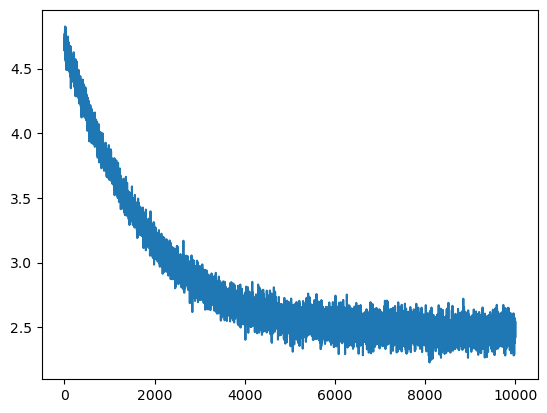

In [314]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.plot(losses)

In [317]:
print(decode(m.generate(idx,100)[0].tolist()))


t be a in he swe hilisa mathen iofu.
Hoofoull;XBarlf nce hear;
ThersorTovis I ient INores r
Dea wher


# this is as good as we can get when only taking one letter of context for each prediction

## convert this code and put it into a script: bigram.py

